In [1]:
#solve the low thrust optimization problem as an nlp 

#we want to be able to match this solution with the polynomial optimization methods
using Pkg
Pkg.activate(".")

  Activating project at `~/Research/polynomial_opt`


In [2]:
using Test 
using LinearAlgebra
using SparseArrays
using Plots
using ForwardDiff
import lazy_nlp_qd 

In [3]:
#sizes of all the states 
nq = 3
nv = 3
na = 3
nr = 1
nu = 3

3

In [4]:
#gravitational parameter for the Earth 
μ = 3.986004418e5 #km3/s2

398600.4418

In [5]:
#iss initial conditions
r0 = [6791.0; 0; 0] #km
v0 = [0; cosd(51.5)*7.66; sind(51.5)*7.66] #km/s
x_initial_0 = [r0; v0]

6-element Vector{Float64}:
 6791.0
    0.0
    0.0
    0.0
    4.768462116644166
    5.994778481489491

In [6]:
#finding the period
r_initial = norm(r0)

#for 1 rev
iss_period = 2*pi*sqrt(r_initial^3/μ)

5569.440597283014

In [7]:
#working for 1 rev ...
#revs = 1

#around 8 min solve time... (working)
#revs = 10

#revs for polynomial opt example (working) 4 second solve time 
revs = 5

#period 
period = revs*iss_period 

27847.202986415068

In [8]:
#working with 10 rev horizon 
#knot_pts = 30

#course discretization that we try out in the polynomial opt example
#working with 5 rev horizon
knot_pts = 10

#number of knot points  
N=knot_pts*revs

50

In [9]:
#define a timestep
#in seconds 
h = period/(N-1) 

568.3102650288789

In [10]:
function two_body_dynamics(x)

    q = x[1:3]
    v = x[4:6]

    a = zeros(eltype(x), size(x))

    r = norm(q)
    
    a[1:3] = v

    a[4:6] = (-μ/r^3)*q

    return a

end

two_body_dynamics (generic function with 1 method)

In [11]:
#semi implicit euler 
function symplectic_euler(x)

    #the q and the v are already scaled 
    q = x[1:3]
    v = x[4:6]

    #next timestep
    xnext = zeros(6)

    #ak = two_body_dynamics(x)[4:6]
    ak = (-μ/(norm(q)^3))*q
    #ak = (-μ_scaled/(norm(q)^3))*q


    #explicit euler on the velocities
    #vk1
    xnext[4:6] = v + h*ak

    #implicit euler on the positions
    #qk1
    xnext[1:3] = q + h*xnext[4:6]

    return xnext 

end

symplectic_euler (generic function with 1 method)

In [12]:
#integrate the orbit with symplectic euler to see if it closes

xtraj = zeros(6, N)

xtraj[:,1] = x_initial_0


6-element Vector{Float64}:
 6791.0
    0.0
    0.0
    0.0
    4.768462116644166
    5.994778481489491

In [13]:
#integrate using symplectic Euler to generate an initial guess
for i=1:N-1

    xtraj[:,i+1] = symplectic_euler(xtraj[:,i])

end


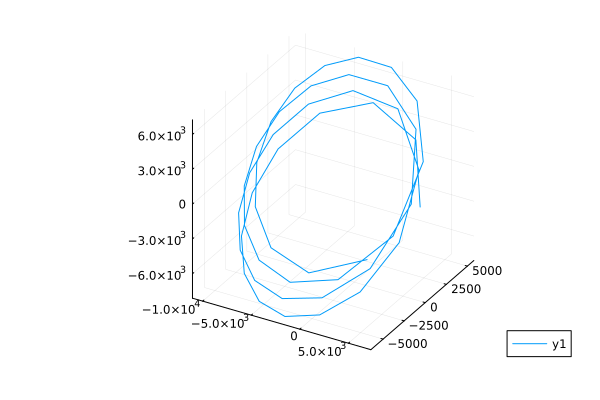

In [14]:
plot(xtraj[1,:], xtraj[2,:], xtraj[3,:])

In [15]:
period 

27847.202986415068

In [16]:
#going to scale position by semi major axis length 
position_scale = r_initial 

#scaled to make the period 1 
#time_scale = iss_period 
#works with 1
#thrust_limit_kN = 0.000432

#this works with 29% sub opt gap  (block structure)
#0.6% opt gap with MD structure 
#this is working...
#thrust_limit_kN = 0.00002

#2 Newtons 
#thrust_limit_kN = 0.002

#2 milliNewton
#thrust_limit_kN = 0.000002

thrust_limit_kN = 20e-9

#currently in the testing code
#this works 
#thrust_limit_kN = 2e-5

#scale to make the minimum control 1
#time_scale = sqrt(position_scale/thrust_limit_kN)

#scaled to make the period 1
time_scale = period 

velocity_scale = position_scale/time_scale

acceleration_scale = position_scale/time_scale^2

μ_scaled = μ/(position_scale^3/time_scale^2)

h_scaled = h/time_scale

u_max_bound = thrust_limit_kN/acceleration_scale 

0.002283807139350918

In [57]:
h_scaled 

0.02040816326530612

In [56]:
time_scale 

27847.202986415068

In [17]:
xtraj_scaled = [xtraj[1:3,:]./position_scale; xtraj[4:6,:]./velocity_scale]

6×50 Matrix{Float64}:
  1.0       0.588938   -0.189128  …   -0.82113   -0.173729   0.552223
  0.0       0.399053    0.549431      -0.507161  -0.593281  -0.411152
  0.0       0.501678    0.69073       -0.637589  -0.745857  -0.516889
  0.0     -20.142     -38.1252        21.0361    31.7226    35.5716
 19.5536   19.5536      7.36855      -10.8203    -4.21991    8.92434
 24.5822   24.5822      9.26353   …  -13.603     -5.30515   11.2194

In [18]:
#solve for a_traj_scaled
a_traj_scaled = zeros(3, N)


for i=1:N

    a_traj_scaled[:,i] = (-μ_scaled/(norm(xtraj_scaled[1:3, i])^3))*xtraj_scaled[1:3, i] 

end

In [19]:
a_traj_scaled 

3×50 Matrix{Float64}:
 -986.96  -881.175   253.815  …  521.799  523.642  188.601  -854.156
   -0.0   -597.066  -737.353     119.487  323.421  644.068   635.954
   -0.0   -750.615  -926.98      150.215  406.596  809.704   799.503

In [20]:
#updated for u and n variables in the ipopt projection problem

function create_idx(nq, nv, na, nr, nu, N)

    # This function creates some useful indexing tools for Z 
    # q_i = Z[idx.q[i]]
    # v_i = Z[idx.v[i]]
    # a_i = Z[idx.a[i]]
    # r_i = Z[idx.r[i]]
    # u_i = Z[idx.u[i]]

    #stacked up vector 
    # z = [all_q, all_v, all_a, all_r, all_u]

    #length of the entire stacked up vector 
    nz = (N*nq) + (N*nv) + (N*na) + N*(nr) + ((N-1)*nu) 

    q = [(i-1)*(nq) .+ (1:nq) for i=1:N]

    v = [(i-1)*(nv) .+ (nq*N+1:nq*N+nv) for i=1:N]

    a = [(i-1)*(na) .+ (nq*N+ nv*N + 1:nq*N+ nv*N+na) for i=1:N]

    r = [(i-1)*(nr) .+ (nq*N+ nv*N + na*N +nr) for i=1:N]

    u = [(i-1)*(nu) .+ (nq*N+ nv*N + na*N + nr*N+1:nq*N+ nv*N + na*N + nr*N +nu) for i=1:N-1]


    #total number of dynamics constraints 
    nd = (nq*(N-1)) + (nv*(N-1)) + (na*N)

    #position integrator constraint 
    cq = [(i-1)*(nq) .+ (1:nq) for i=1:N-1]

    #velocity integrator constraint 
    cv = [(i-1)*(nv) .+ ((nq*(N-1))+1:(nq*(N-1)) + nv) for i=1:N-1]

    #acceleration constraint at each knot point 
    ca = [(i-1)*(na) .+ ((nq*(N-1)) + (nv*(N-1))+1:(nq*(N-1)) +(nv*(N-1))+ na) for i=1:N]
    
    return (q=q,v=v,N=N,a=a,r=r, u= u, cq = cq, cv = cv, ca = ca, nd= nd, nz= nz)

end

create_idx (generic function with 1 method)

In [21]:
idx_1 = create_idx(nq, nv, na, nr, nu, N)

(q = UnitRange{Int64}[1:3, 4:6, 7:9, 10:12, 13:15, 16:18, 19:21, 22:24, 25:27, 28:30  …  121:123, 124:126, 127:129, 130:132, 133:135, 136:138, 139:141, 142:144, 145:147, 148:150], v = UnitRange{Int64}[151:153, 154:156, 157:159, 160:162, 163:165, 166:168, 169:171, 172:174, 175:177, 178:180  …  271:273, 274:276, 277:279, 280:282, 283:285, 286:288, 289:291, 292:294, 295:297, 298:300], N = 50, a = UnitRange{Int64}[301:303, 304:306, 307:309, 310:312, 313:315, 316:318, 319:321, 322:324, 325:327, 328:330  …  421:423, 424:426, 427:429, 430:432, 433:435, 436:438, 439:441, 442:444, 445:447, 448:450], r = [451, 452, 453, 454, 455, 456, 457, 458, 459, 460  …  491, 492, 493, 494, 495, 496, 497, 498, 499, 500], u = UnitRange{Int64}[501:503, 504:506, 507:509, 510:512, 513:515, 516:518, 519:521, 522:524, 525:527, 528:530  …  618:620, 621:623, 624:626, 627:629, 630:632, 633:635, 636:638, 639:641, 642:644, 645:647], cq = UnitRange{Int64}[1:3, 4:6, 7:9, 10:12, 13:15, 16:18, 19:21, 22:24, 25:27, 28:30  … 

In [22]:
#dynamics equality constraints 

function dynamics_constraints(params, Z::Vector)

    idx, N = params.idx, params.N

    c = zeros(eltype(Z), idx.nd)

    #position constraints
    for i=1:(N-1)

        c[idx.cq[i]] = Z[idx.q[i+1]] - (Z[idx.q[i]] + h_scaled*Z[idx.v[i+1]])

    end

    #velocity constraints 
    for i=1:(N-1)

        c[idx.cv[i]] = Z[idx.v[i+1]] - (Z[idx.v[i]] + h_scaled*(Z[idx.a[i]] + Z[idx.u[i]]))

    end

    #acceleration constraint
    for i=1:N
        
        c[idx.ca[i]] = Z[idx.a[i]]*Z[idx.r[i]]^3 + μ_scaled*Z[idx.q[i]]

    end


    return c 

end

dynamics_constraints (generic function with 1 method)

In [23]:
function slack_constraint(params, Z::Vector)

    idx = params.idx

    c = zeros(eltype(Z), idx.N)

    #slack constraint at each knot point 

    for i=1:N 

        c[i] = Z[idx.r[i]]^2 - Z[idx.q[i]]'*Z[idx.q[i]]

    end

    return c 
    
end

slack_constraint (generic function with 1 method)

In [24]:
#works 

function cost(params, Z::Vector )


    idx, N = params.idx, params.N

    J = 0.0

    #minimize over the slack variable r 
    
    for i=1:N

        J += Z[idx.r[i]]

    end

    #add in the control regularizing term? 

    return J 

end

cost (generic function with 1 method)

In [25]:
function cost_gradient(params, Z)

    return [zeros(nq*N); zeros(nv*N); zeros(na*N); ones(nr*N); zeros(nu*(N-1))]
    
end

cost_gradient (generic function with 1 method)

In [26]:
# grad_test = zeros(387)

# cost_gradient!(params, grad_test, x_initial) 

# grad_test 

In [27]:
#this is to test the cost gradient to make sure it is correct 

# cost_gradient = ForwardDiff.gradient(dZ -> cost(params, dZ), x_initial)  

In [28]:
function equality_constraints(params, Z::Vector)

    #xic is the initial condition 

    idx, xic = params.idx, params.xic

    return [
    
    #initial position 
    Z[idx.q[1]] - xic[1:3]; 

    #initial velocity 
    Z[idx.v[1]] - xic[4:6]; 

    #dynamics constraints
    dynamics_constraints(params, Z);

    #slack constraint 
    slack_constraint(params, Z)

    ]

    
end

equality_constraints (generic function with 1 method)

In [29]:
#do not need this, can represent state bounds through xl and xu in the wrapper 

# function inequality_slack_constraint(params, Z::Vector)

#     #constraints are r>0.75 and r>0

#     idx, N = params.idx, params.N
 
#     c1 = zeros(eltype(Z), N)

#     c2 = zeros(eltype(Z), N)

#     c = zeros(eltype(Z), 2*N)

#     #r>0.75 constraint 
#     for i=1:N

#         c1[i] = 0.75 - Z[idx.r[i]]

#     end

#     #r>0 constraint
#     for i=1:N

#         c2[i] = -Z[idx.r[i]]

#     end

#     c[1:N] = c1
#     c[N+1:2*N] = c2

#     return c 

# end

In [30]:
#no inequality constraints other than state bounds 
# function inequality_constraints(params, Z)

#     return inequality_slack_constraint(params, Z)

# end

In [31]:
#in place function for the constraints 
#seems good 
function all_constraints(params, Z)

    return equality_constraints(params, Z)

end

all_constraints (generic function with 1 method)

In [32]:
function con(params, Z)

    return equality_constraints(params, Z)
    
end 

con (generic function with 1 method)

In [33]:
#seems good
function all_constraints_jacobian(params, Z)

    return ForwardDiff.jacobian(dZ -> con(params, dZ), Z)

end 

all_constraints_jacobian (generic function with 1 method)

In [34]:
#we have no inequality constraints 
c_l = zeros(0)

c_u = zeros(0)

Float64[]

In [35]:
x_l = -Inf*ones(idx_1.nz)
x_u = Inf*ones(idx_1.nz)

647-element Vector{Float64}:
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
  ⋮
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf

In [36]:
#bound the states 

for i = 1:N

    #lower bounds 
    x_l[idx_1.q[i]] .= -2.0
    x_l[idx_1.v[i]] .= -200.0
    x_l[idx_1.r[i]] = 0.75

    #upper bounds
    x_u[idx_1.q[i]] .= 2.0
    x_u[idx_1.v[i]] .= 200.0
    x_u[idx_1.r[i]] = 2.0

end



#bound the controls 
#in scaled units 
for i=1:N-1

    x_l[idx_1.u[i]] .= -u_max_bound

    x_u[idx_1.u[i]] .= u_max_bound

end

In [37]:
#get the initial guess

x_initial = zeros(idx_1.nz)


#fill out the states

for i=1:N

    x_initial[idx_1.q[i]] = xtraj_scaled[1:3, i]
    x_initial[idx_1.v[i]] = xtraj_scaled[4:6, i]
    x_initial[idx_1.a[i]] = a_traj_scaled[:,i] 
    x_initial[idx_1.r[i]] = norm(xtraj_scaled[1:3, i])

end

#fill out the controls
#zeros for now 
for i=1:N-1

    x_initial[idx_1.u[i]] = zeros(3)

end

In [38]:
x_initial 

647-element Vector{Float64}:
  1.0
  0.0
  0.0
  0.5889377592216012
  0.3990525650552518
  0.5016778306000167
 -0.18912761601031128
  0.5494310726335986
  0.6907295246802885
 -0.8614807812120573
  ⋮
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0

In [39]:
#define the parameters 
params = (N = N, idx = idx_1, xic = xtraj_scaled[:, 1])

(N = 50, idx = (q = UnitRange{Int64}[1:3, 4:6, 7:9, 10:12, 13:15, 16:18, 19:21, 22:24, 25:27, 28:30  …  121:123, 124:126, 127:129, 130:132, 133:135, 136:138, 139:141, 142:144, 145:147, 148:150], v = UnitRange{Int64}[151:153, 154:156, 157:159, 160:162, 163:165, 166:168, 169:171, 172:174, 175:177, 178:180  …  271:273, 274:276, 277:279, 280:282, 283:285, 286:288, 289:291, 292:294, 295:297, 298:300], N = 50, a = UnitRange{Int64}[301:303, 304:306, 307:309, 310:312, 313:315, 316:318, 319:321, 322:324, 325:327, 328:330  …  421:423, 424:426, 427:429, 430:432, 433:435, 436:438, 439:441, 442:444, 445:447, 448:450], r = [451, 452, 453, 454, 455, 456, 457, 458, 459, 460  …  491, 492, 493, 494, 495, 496, 497, 498, 499, 500], u = UnitRange{Int64}[501:503, 504:506, 507:509, 510:512, 513:515, 516:518, 519:521, 522:524, 525:527, 528:530  …  618:620, 621:623, 624:626, 627:629, 630:632, 633:635, 636:638, 639:641, 642:644, 645:647], cq = UnitRange{Int64}[1:3, 4:6, 7:9, 10:12, 13:15, 16:18, 19:21, 22:24, 2

In [40]:
function inequality_constraints(params, Z)

    return zeros(eltype(Z), 0)

end

inequality_constraints (generic function with 1 method)

In [41]:
diff_type = :auto 

:auto

In [42]:
    """ we are solving the following problem:
    
        minimize_x        cost(x)
        subject to        c_L <= constraint(x) <= c_U
                          x_L <= x <= x_U
    """
 
    Z = lazy_nlp_qd.fmincon_dense(cost::Function,
                                   all_constraints::Function,
                                   inequality_constraints::Function,
                                   x_l::Vector,
                                   x_u::Vector,
                                   c_l::Vector,
                                   c_u::Vector,
                                   x_initial::Vector,
                                   params::NamedTuple,
                                   diff_type::Symbol; 
                                   tol = 1e-4,
                                   c_tol = 1e-4,
                                   max_iters = 1_000,
                                   verbose = true)

---------checking dimensions of everything----------
---------all dimensions good------------------------
---------diff type set to :auto (ForwardDiff.jl)----
---------testing objective gradient-----------------
---------testing constraint Jacobian----------------
---------successfully compiled both derivatives-----
---------IPOPT beginning solve----------------------

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:   323500
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian..

647-element Vector{Float64}:
  1.0
  0.0
  9.543211968502045e-34
  0.5889387065360502
  0.3990516160276075
  0.5016768811280662
 -0.1891257935163508
  0.5494285249373895
  0.6907269005952236
 -0.8614767675654912
  ⋮
  0.0022831844191266086
  0.001904039987219151
  0.0020094598574689967
 -0.000813953044385666
  0.0014808560139871548
  0.0016209190548754295
 -0.0007405993113172411
  0.0005520356934439123
  0.0006912179450730591

In [43]:
# pull the X and U solutions out of Z 
#this is a vector of vectors 
q_vector = [Z[idx_1.q[i]] for i = 1:N]
v_vector  = [Z[idx_1.v[i]] for i = 1:(N)]
a_vector = [Z[idx_1.a[i]] for i = 1:(N)]
r = [Z[idx_1.r[i]] for i = 1:(N)]
u_vector = [Z[idx_1.u[i]] for i = 1:(N-1)]

49-element Vector{Vector{Float64}}:
 [0.002274501991893265, -0.0022786153738946734, -0.002279682153015275]
 [0.002280742281593273, -0.002277384754693606, -0.0022787008166676574]
 [0.0022812175631469426, 0.0021685777418204303, 0.0021891822034033315]
 [0.002279863889163772, 0.0022735351342569364, 0.002275657042235153]
 [0.0022760094723453385, 0.0022748649553195437, 0.0022767060576680204]
 [0.002260032365707475, 0.002273543960237916, 0.0022756514938244827]
 [-0.0022156681571397154, 0.002270280147730249, 0.002273047827779566]
 [-0.0022651010498204644, 0.0022628588931931973, 0.002267119083991776]
 [-0.002271450577378028, 0.002233873351190225, 0.0022438014418066777]
 [-0.0022737925819419687, -0.0021928016983009174, -0.002210457684351718]
 ⋮
 [0.0022605072623839645, -0.0021924232174646507, -0.0022095730737563056]
 [0.002254253011499223, -0.0016067523042713582, -0.0017479873245756937]
 [0.00224172588259728, 0.001957948577144012, 0.002059330770454782]
 [0.0022161246871724174, 0.0021145381668494

In [44]:
#this is the norm of each position of the trajectory with no control 
rtraj_scaled = [norm(xtraj_scaled[1:3, i]) for i=1:N] 

50-element Vector{Float64}:
 1.0
 0.8705005914011062
 0.9026356047587021
 1.067758416077571
 1.253985154481515
 1.4053925697117327
 1.5053446774632604
 1.5496242761365508
 1.5373769914785478
 1.4687901308767293
 ⋮
 1.428587944139719
 1.5214759634079358
 1.5583683840862907
 1.5386619997007622
 1.462638510907922
 1.3323537487310935
 1.1567135034066984
 0.9687452793882805
 0.8609123562947627

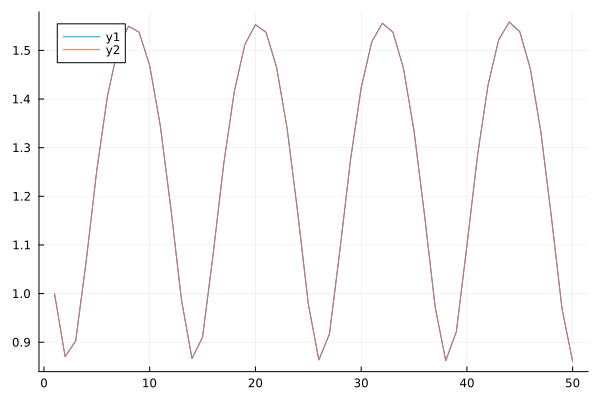

In [45]:
plot(rtraj_scaled)

#r is the norm of the position of the trajectory with control applied 
plot!(r) 

In [46]:
#r at the end of the 10 revolutions when no control is applied (in km)
rtraj_scaled[end]*position_scale 

5846.455811597733

In [47]:
#r at the end of 10 revolutions when low thrust is applied (in km)
r[end]*position_scale 

5843.944444314007

In [48]:
#at the end, r decreases by 10 km. takes 8 min to compute a solution for 10 revs.

In [49]:
#transform into matrices for plotting 
q = zeros(3, N)
v = zeros(3, N)
a = zeros(3, N)
u = zeros(3, N-1)


for i=1:N

    q[:,i] = q_vector[i]
    v[:,i] = v_vector[i]
    a[:,i] = a_vector[i]

end

for i=1:N-1

    u[:,i] = u_vector[i]
    
end

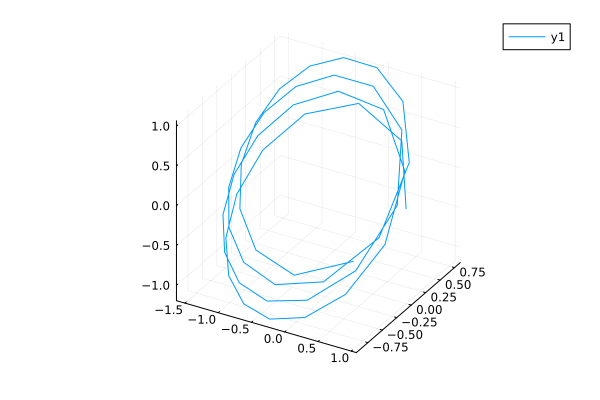

In [50]:
plot(q[1,:], q[2,:], q[3,:])

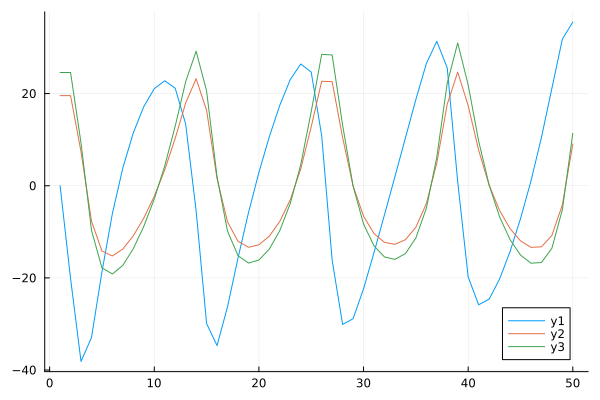

In [51]:
plot(v[1,:])
plot!(v[2,:])
plot!(v[3,:])

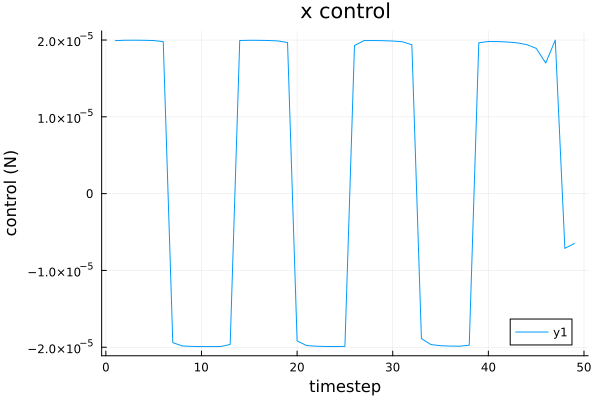

In [52]:
plot(u[1,:]*acceleration_scale*1e3, title="x control", xlabel="timestep", ylabel="control (N)")

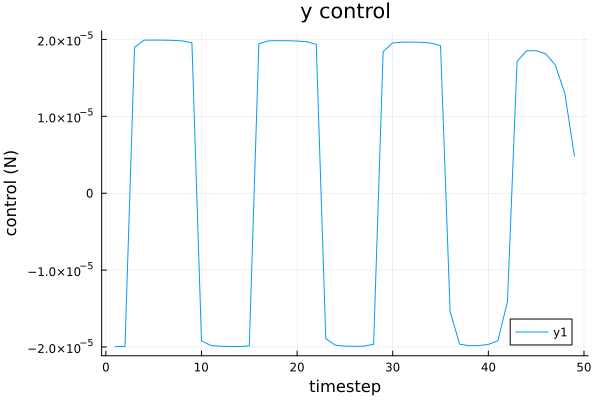

In [53]:
plot(u[2,:]*acceleration_scale*1e3, title="y control", xlabel="timestep", ylabel="control (N)")

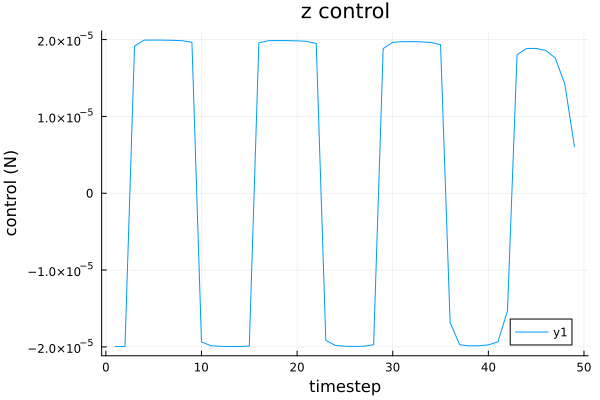

In [54]:
plot(u[3,:]*acceleration_scale*1e3, title="z control", xlabel="timestep", ylabel="control (N)") 